**This is the notebook for BeFR's model training.**
>In this notebook, we will use a Kaggle dataset to train a CNN model to classify real and deepfake images using a supervised learning process.

You can find all files for the full project here: https://github.com/ennovak/BeFR-Deepfake-Detection

**HOW TO USE:**
>Before running this notebook, it is important to allow GPU usage for Colab if you have access to it. This will significantly reduce training time. To do so, click on the "Runtime" tab in the top-left and navigate to "change runtime type". There, you'll be able to switch the runtime to an available GPU. Once you've done that, you can simply click "Run all"!

# **1. Import Necessary Libraries**

In [ ]:
# install dependencies
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 2.1 MB/s eta 0:00:00


In [ ]:
# import libraries
import torch
import os
import random
import numpy as np
import joblib
import io

# database handling
import kagglehub
import pandas as pd
from torch.utils.data import DataLoader

# image processing
from PIL import Image, ImageFilter
import cv2

# visualization
import matplotlib.pyplot as plt

# model training
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Configure TensorFlow to use mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

## Checking/Setting Computation Device

Utilizing pyTorch support of GPU training of neural networks to speed up training process.

In [ ]:
use_cuda = torch.cuda.is_available()

# Use this line below to enforce the use of the CPU (in case you don't have a supported GPU)
# use_cuda = False  # Uncomment this line to force CPU usage

device = torch.device("cuda:0" if use_cuda else "cpu")

print("Available device: {}".format(device))
print("If you see 'cuda:0', it means GPU is available and will be used")
print("If you see 'cpu', it means only CPU will be used")

Available device: cpu
If you see 'cuda:0', it means GPU is available and will be used
If you see 'cpu', it means only CPU will be used


# **2. Data Analysis and Preprocessing**

In [ ]:
# import data

# Download latest version
path = kagglehub.dataset_download("ayushmandatta1/deepdetect-2025")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'deepdetect-2025' dataset.
Path to dataset files: /kaggle/input/deepdetect-2025


In [ ]:
# find train directory
train_dir = os.path.join(path, "ddata", "train")

# find test directory
test_dir = os.path.join(path, "ddata", "test")

In [ ]:
# create datasets
train_filepaths = []
train_labels = []
for label in ['real', 'fake']:
  class_dir = os.path.join(train_dir, label)
  for filename in os.listdir(class_dir):
    train_filepaths.append(os.path.join(class_dir, filename))
    train_labels.append(label)
train_df = pd.DataFrame({"image_path": train_filepaths, "label": train_labels})

test_filepaths = []
test_labels = []
for label in ['real', 'fake']:
  class_dir = os.path.join(test_dir, label)
  for filename in os.listdir(class_dir):
    test_filepaths.append(os.path.join(class_dir, filename))
    test_labels.append(label)
test_df = pd.DataFrame({"image_path": test_filepaths, "label": test_labels})

Dataset Information:
Training data shape: (90409, 2)
Testing data shape: (21776, 2)
Labels: ['real' 'fake']

Training Image Distribution:
label
real    48815
fake    41594
Name: count, dtype: int64



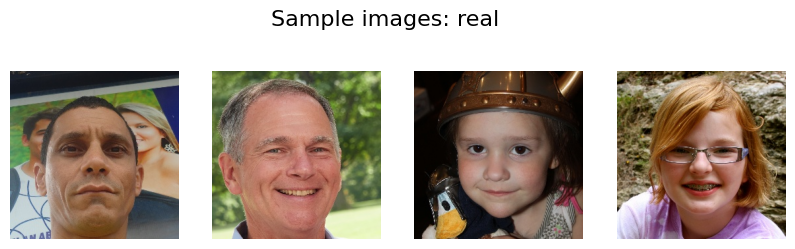

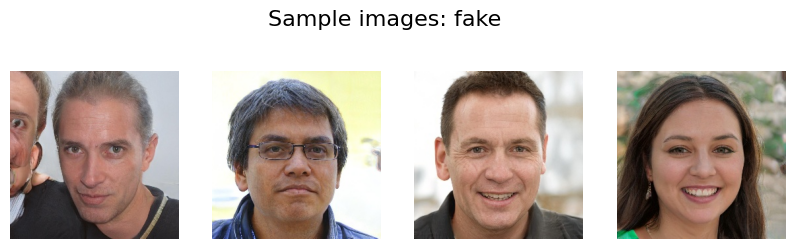

In [ ]:
# display brief data information to confirm successful import
print("Dataset Information:")
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")
print(f"Labels: {train_df['label'].unique()}")
print(f"\nTraining Image Distribution:")
print(train_df['label'].value_counts())
print() # add whitespace

# show some sample images
def display_sample_images(dataframe, category, num_samples=4):
    plt.figure(figsize=(10, 3))
    plt.suptitle(f"Sample images: {category}", fontsize=16)

    # Filter the dataframe for the specified category
    category_df = dataframe[dataframe["label"] == category]

    # Select random image paths from the filtered dataframe
    image_filepaths = random.sample(category_df["image_path"].tolist(), num_samples)


    for i, img_path in enumerate(image_filepaths):
        img = Image.open(img_path)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

# Show 4 random real images
display_sample_images(train_df, "real")

# Show 4 random deepfake images
display_sample_images(train_df, "fake")

In [ ]:
train_df['label'] = train_df['label'].replace({'real': 0, 'fake': 1})
test_df['label'] = test_df['label'].replace({'real': 0, 'fake': 1})

# split the datasets into images and labels
X_train = train_df["image_path"]
y_train = train_df["label"]
X_test = test_df["image_path"]
y_test = test_df["label"]

# check shape
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
train_length = len(X_train)
test_length = len(X_test)

X_train shape: (90409,)
X_test shape: (21776,)


/tmp/ipython-input-3106814188.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['label'] = train_df['label'].replace({'real': 0, 'fake': 1})
/tmp/ipython-input-3106814188.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['label'] = test_df['label'].replace({'real': 0, 'fake': 1})


## Image Preprocessing

In [ ]:
def is_valid_image(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()  # Verify the image file
        return True
    except (IOError, Image.UnidentifiedImageError, SyntaxError) as e:
        # Catch various errors that indicate an invalid or corrupted image
        return False

print("Function 'is_valid_image' defined successfully.")

Function 'is_valid_image' defined successfully.


In [ ]:
print("Validating training images...")
valid_train_filepaths = []
valid_train_labels = []
corrupted_train_count = 0
for i, image_path in enumerate(X_train):
    if is_valid_image(image_path):
        valid_train_filepaths.append(image_path)
        valid_train_labels.append(y_train.iloc[i])
    else:
        corrupted_train_count += 1

print(f"Found {corrupted_train_count} corrupted training images.")

print("Validating test images...")
valid_test_filepaths = []
valid_test_labels = []
corrupted_test_count = 0
for i, image_path in enumerate(X_test):
    if is_valid_image(image_path):
        valid_test_filepaths.append(image_path)
        valid_test_labels.append(y_test.iloc[i])
    else:
        corrupted_test_count += 1

print(f"Found {corrupted_test_count} corrupted test images.")

print("Image validation complete. Corrupted images filtered out.")

Validating training images...


In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128

def _decode_and_resize_image_pil(image_bytes):
    # Helper function to be wrapped by tf.py_function
    try:
        # Use BytesIO to open image from bytes
        img = Image.open(io.BytesIO(image_bytes.numpy()))
        # Ensure RGB format
        if img.mode != 'RGB':
            img = img.convert('RGB')
        # Resize using PIL
        img = img.resize((IMG_WIDTH, IMG_HEIGHT), Image.Resampling.LANCZOS)
        return np.array(img)
    except (IOError, Image.UnidentifiedImageError, SyntaxError) as e:
        print(f"PIL decoding failed for an image: {e}")
        # Return a recognizable dummy array for filtering if PIL fails
        return np.full((IMG_WIDTH, IMG_HEIGHT, 3), -1, dtype=np.float32) # Use -1 to mark as corrupted

def preprocess_image(image_path, label):
    try:
        # Read the image file
        img_raw = tf.io.read_file(image_path)

        # Use tf.py_function to decode and resize with PIL
        # The output of py_function must be specified with Tout and shape_out
        img = tf.py_function(
            func=_decode_and_resize_image_pil,
            inp=[img_raw],
            Tout=tf.float32,
            name='pil_decode_and_resize'
        )
        # Ensure the shape is known after py_function
        img.set_shape([IMG_WIDTH, IMG_HEIGHT, 3])

        # Check if it's a dummy image from PIL failure
        # We'll consider any image where all pixels are -1 to be a dummy
        is_dummy = tf.reduce_all(tf.equal(img, -1.0))
        if is_dummy:
            dummy_image = tf.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype=tf.float32)
            dummy_label = tf.constant(-1, dtype=tf.int64) # Mark this sample to be filtered out
            return dummy_image, dummy_label

        # Convert image to float32. EfficientNet's preprocess_input will handle normalization.
        img = tf.cast(img, tf.float32)
        return img, tf.cast(label, tf.int64) # Explicitly cast label to int64 to prevent dtype mismatch errors
    except Exception as e:
        print(f"Error in preprocess_image (TF side): {e}")
        # Fallback for any other unexpected TF errors during preprocessing
        dummy_image = tf.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype=tf.float32)
        dummy_label = tf.constant(-1, dtype=tf.int64)
        return dummy_image, dummy_label

## Create datasets
> Here I am implementing Tensorflow's datasets for dynamic loading and preprocessing during model training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 256

# Create tf.data.Dataset for training data from valid images
train_ds = tf.data.Dataset.from_tensor_slices((valid_train_filepaths, valid_train_labels))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.filter(lambda img, label: tf.not_equal(label, -1))
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.repeat() # Add .repeat() to ensure data is available for all epochs
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

# Create tf.data.Dataset for test data from valid images
test_ds = tf.data.Dataset.from_tensor_slices((valid_test_filepaths, valid_test_labels))
test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.filter(lambda img, label: tf.not_equal(label, -1))
test_ds = test_ds.batch(batch_size)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

print("TensorFlow datasets for training and testing recreated with updated preprocessing.")
# Calculate and print actual dataset sizes for verification (this might be slow for large datasets)
# For repeated datasets, tf.data.experimental.cardinality returns UNKNOWN. So we print approximate numbers.
print(f"Approximate training dataset size: {len(valid_train_filepaths) // batch_size} samples")
print(f"Approximate test dataset size: {len(valid_test_filepaths) // batch_size} samples")

In [ ]:
from sklearn.utils import class_weight

# Assuming y_train contains the original labels for the full training set (before subsetting)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(valid_train_labels),
    y=valid_train_labels
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"Computed class weights: {class_weights_dict}")

In [ ]:
for images, labels in train_ds.take(1):
    print("Shape of images in the batch:", images.shape)
    print("Labels in the batch:", labels.numpy())

    plt.figure(figsize=(10, 10))
    # Select 9 random indices from the batch
    num_samples_to_display = min(9, images.shape[0])
    random_indices = random.sample(range(images.shape[0]), num_samples_to_display)

    for i, idx in enumerate(random_indices):
        ax = plt.subplot(3, 3, i + 1)
        # Undo standardization for display by clipping values to [0,1] or original range
        # For display, we can scale values back to 0-1, as per_image_standardization makes mean=0, std=1
        # Displaying standardized images directly might show weird colors.
        # A common approach for visualization after standardization is to just clip/rescale for display.
        display_img = images[idx].numpy()
        display_img = (display_img - display_img.min()) / (display_img.max() - display_img.min())
        plt.imshow(display_img)
        plt.title(f"Label: {labels[idx].numpy()}")
        plt.axis("off")
    plt.show()

# **3. Model Training**

In [ ]:
def create_model(hp):
    # Define the input shape for the images
    input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

    # Instantiate EfficientNetB0 as the base model
    base_model = EfficientNetB0(
        include_top=False, # Exclude the classification head
        weights='imagenet', # Load pre-trained ImageNet weights
        input_shape=input_shape
    )

    # Freeze the layers of the base_model
    base_model.trainable = False

    # Create a Sequential model for the classification head
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape), # Explicitly define input for the Sequential model
        # Preprocess input for EfficientNet
        tf.keras.layers.Lambda(preprocess_input), # Wrap preprocess_input in a Lambda layer
        # Data Augmentation Layers
        tf.keras.layers.RandomFlip("horizontal"), # Randomly flip images horizontally
        tf.keras.layers.RandomRotation(hp.Float('rotation_factor', min_value=0.05, max_value=0.2, step=0.05)), # Randomly rotate images
        tf.keras.layers.RandomZoom(hp.Float('zoom_factor', min_value=0.1, max_value=0.3, step=0.1)), # Randomly zoom in/out
        tf.keras.layers.RandomBrightness(factor=hp.Float('brightness_factor', min_value=0.1, max_value=0.3, step=0.05)),
        tf.keras.layers.RandomContrast(factor=hp.Float('contrast_factor', min_value=0.1, max_value=0.3, step=0.05)),
        tf.keras.layers.RandomHue(factor=hp.Float('hue_factor', min_value=0.05, max_value=0.15, step=0.05)), # Changed 'delta' to 'factor'
        base_model, # Add the frozen base model
        tf.keras.layers.GlobalAveragePooling2D(), # Global average pooling layer
        # Add one or more Dense layers for classification
        tf.keras.layers.Dense(units=hp.Int('dense_units', min_value=32, max_value=256, step=64), activation='relu'),
        tf.keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)), # Optional Dropout layer
        # Final Dense output layer for binary classification
        tf.keras.layers.Dense(1, activation='sigmoid', dtype='float32') # Use float32 for output layer in mixed precision
    ])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Define the total size of the subset (10% of full dataset) for hyperparameter tuning
total_subset_size_train = train_length * 0.1  # Total images for train subset, will be split 50/50
total_subset_size_test = test_length * 0.1    # Total images for test subset, will be split 50/50

# Calculate samples per class for balanced subsets
samples_per_class_train = int(total_subset_size_train / 2)
samples_per_class_test = int(total_subset_size_test / 2)

# --- Create balanced training subset from validated data ---
# Create a temporary DataFrame from the validated lists for easy sampling
validated_train_df = pd.DataFrame({"image_path": valid_train_filepaths, "label": valid_train_labels})

train_real_subset = validated_train_df[validated_train_df['label'] == 0].sample(n=samples_per_class_train, random_state=42)
train_fake_subset = validated_train_df[validated_train_df['label'] == 1].sample(n=samples_per_class_train, random_state=42)
balanced_train_df_subset = pd.concat([train_real_subset, train_fake_subset]).sample(frac=1, random_state=42).reset_index(drop=True)

X_train_subset = balanced_train_df_subset["image_path"]
y_train_subset = balanced_train_df_subset["label"]

# --- Create balanced test subset from validated data ---
# Create a temporary DataFrame from the validated lists for easy sampling
validated_test_df = pd.DataFrame({"image_path": valid_test_filepaths, "label": valid_test_labels})

test_real_subset = validated_test_df[validated_test_df['label'] == 0].sample(n=samples_per_class_test, random_state=42)
test_fake_subset = validated_test_df[validated_test_df['label'] == 1].sample(n=samples_per_class_test, random_state=42)
balanced_test_df_subset = pd.concat([test_real_subset, test_fake_subset]).sample(frac=1, random_state=42).reset_index(drop=True)

X_test_subset = balanced_test_df_subset["image_path"]
y_test_subset = balanced_test_df_subset["label"]

print(f"Created balanced training subset of size: {len(X_train_subset)} (Real: {y_train_subset.value_counts().get(0,0)}, Fake: {y_train_subset.value_counts().get(1,0)}) ")
print(f"Created balanced test subset of size: {len(X_test_subset)} (Real: {y_test_subset.value_counts().get(0,0)}, Fake: {y_test_subset.value_counts().get(1,0)})\n")


# --- Re-create TensorFlow Datasets with Subsets ---
AUTOTUNE = tf.data.AUTOTUNE
small_batch_size = 64

# Create tf.data.Dataset for training data from the valid image subsets
train_ds_subset = tf.data.Dataset.from_tensor_slices((X_train_subset, y_train_subset))
train_ds_subset = train_ds_subset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_ds_subset = train_ds_subset.filter(lambda img, label: tf.not_equal(label, -1)) # Keep for robustness if PIL misses something
train_ds_subset = train_ds_subset.shuffle(buffer_size=len(X_train_subset)) # Shuffle buffer size should be at least subset size
train_ds_subset = train_ds_subset.batch(small_batch_size)
train_ds_subset = train_ds_subset.prefetch(buffer_size=AUTOTUNE)

# Create tf.data.Dataset for test data from the valid image subsets
test_ds_subset = tf.data.Dataset.from_tensor_slices((X_test_subset, y_test_subset))
test_ds_subset = test_ds_subset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_ds_subset = test_ds_subset.filter(lambda img, label: tf.not_equal(label, -1)) # Keep for robustness if PIL misses something
test_ds_subset = test_ds_subset.batch(small_batch_size)
test_ds_subset = test_ds_subset.prefetch(buffer_size=AUTOTUNE)

print("TensorFlow debugging datasets created.")
print(f"New training subset size: {len(X_train_subset) // small_batch_size} samples (approx)")
print(f"New test subset size: {len(X_test_subset) // small_batch_size} samples (approx)")

In [ ]:
# define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation accuracy
    patience=3,              # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)

In [ ]:
# perform hyperparameter tuning
import keras_tuner as kt

tuner = kt.BayesianOptimization(
    create_model,         # Model building function
    objective='val_accuracy', # Metric to optimize
    max_trials=20,             # Number of hyperparameter combinations to try
    executions_per_trial=1,   # Number of times to train each model
    project_name='cnn_tuning',
    overwrite=True
)

# Calculate steps for the subset
steps_per_epoch_subset = int((len(X_train_subset) / small_batch_size))

tuner.search(train_ds_subset,
             epochs=10,
             validation_data=test_ds_subset,
             steps_per_epoch=steps_per_epoch_subset,
             callbacks=[early_stopping])

In [ ]:
# define learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', # Monitor validation loss
    factor=0.2,          # Reduce learning rate by a factor of 0.2
    patience=2,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.000001,     # Lower bound on the learning rate
    verbose=1
)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Parameters: {best_hps.values}")

# Create the model with the best hyperparameters (base model layers are initially frozen)
model = create_model(best_hps)

# Identify the EfficientNetB0 base model layer
base_model = None
for layer in model.layers:
    if isinstance(layer, tf.keras.Model) and "efficientnetb0" in layer.name:
        base_model = layer
        break

if base_model is None:
    raise ValueError("EfficientNetB0 base model not found in the sequential model layers.")

# Set all layers in base_model to non-trainable initially, then selectively unfreeze
base_model.trainable = False
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze more layers of EfficientNetB0 for fine-tuning (e.g., last 60 layers)
unfreeze_from_layer = -60

if len(base_model.layers) > abs(unfreeze_from_layer):
    for layer in base_model.layers[unfreeze_from_layer:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            # Keep BatchNormalization layers frozen
            layer.trainable = False
    print(f"EfficientNetB0 base model layers unfrozen for fine-tuning (last {abs(unfreeze_from_layer)} layers), excluding Batch Normalization layers.")
else:
    # If base_model has fewer layers than the unfreeze_from_layer value, unfreeze all, except BN.
    for layer in base_model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
    print("EfficientNetB0 base model layers unfrozen for fine-tuning (all layers, due to small number), excluding Batch Normalization layers.")

# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Calculate steps for the full datasets based on the *validated* filepaths
steps_per_epoch = int(tf.math.ceil(len(valid_train_filepaths) / batch_size))

# fit and evaluate model on the full dataset
print("\nTraining the model on the full dataset...")
model.fit(train_ds,
          epochs=20,
          verbose=2,
          steps_per_epoch=steps_per_epoch,
          validation_data=test_ds,
          callbacks=[early_stopping, lr_scheduler],
          class_weight=class_weights_dict)

print("\nEvaluating the model on the full test dataset...")
loss, acc = model.evaluate(test_ds, verbose=0)
print(f"\nTest accuracy: {acc}")
print(f"Test loss: {loss}")

# **4. Save The Model For Deployment**

In [ ]:
# save CNN model for deployment
print("Saving models for Streamlit deployment...")

# Save the CNN model using TensorFlow's native save format
cnn_filename = 'CNN_model.keras'
model.save(cnn_filename)

print(f"CNN model saved as {cnn_filename}")